In [1]:
## Please follow the instructions from https://github.com/matplotlib/ipympl. In case of runnig into troubles follow https://candid.technology/error-displaying-widget-model-not-found/ or change matplotlib widget to matplotlib inline
%matplotlib widget

# H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001)

We illustrate a simple workflow with the driven and damped qubit example studied in - H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001).

In [2]:
## 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

import numpy as np
from numba import jit

## Library
import qt_unraveling as qtr

# ## Opitonal
# import qt_unraveling.usual_operators_ as op

In [3]:
## Opitonal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

In [4]:
## Parameters 
gamma = 1
omega = 10

## Hamiltonian
H0 = omega/2.0 * qtr.sigmax

## Initial state 
initialState = np.array([1,1], dtype = np.complex128) ## Pure state
# initialState = np.array([[0.5,0.2],[0.1,0.5]], dtype = np.complex128, order='C') ## Mixed state

## Lindblad operators
L = np.sqrt(gamma)*np.array([qtr.sigmam], dtype=np.complex128)

# Unraveling, this matrix must follow the conditions stated on Diosí's paper: |u| <= 1
# ## Fixed unraveling
# u_matrix = np.eye(np.shape(L)[0], dtype=np.complex128)
# h_matrix = 0.5*np.eye(np.shape(L)[0], dtype=np.complex128)

## Ortogonal freedom
# theta = 0
# oMatrix = np.array([[np.cos(theta), -np.sin(theta)],
#                   [np.sin(theta), np.cos(theta)]])

In [5]:
# You have the option to define an adaptive unraveling. This is done by defining it in term of a function of t and the state
# ## Adapative unraveling
@jit(nopython=True)
def u_matrix(t, rho):
    num_op = 1
    uM = np.zeros((num_op,num_op), dtype=np.complex128)
    uM[0,0] = -np.trace(np.dot(rho,qtr.sigmam))/np.trace(np.dot(rho,qtr.sigmap))
    return uM

In [6]:
## Time parameters
t0 = 0
tf = 10
time_steps = 30000
dt = int(abs(tf-t0)/time_steps)

## Time range
timelist = np.linspace(t0, tf, np.int32(time_steps))

## Basic functionalities

This library is based on two main unraveling schemes: quantum jump (QJump) and diffusive schemes. The following shows how you can use the basic functionalities of this library. You can start by using the System class, which gives support to every unraveling method on the library:

In [7]:
%%time
## System definition
qtr_test = qtr.System(H0, initialState, timelist, lindbladList = L, uMatrix = u_matrix)

CPU times: user 5.08 ms, sys: 6.89 ms, total: 12 ms
Wall time: 28.8 ms


/home/deo/.local/lib/python3.9/site-packages/qt_unraveling/qt_unraveling.py:57: UserWarning: Initial state is unnormalized. Normalized state taken instead
  warnings.warn('Initial state is unnormalized. Normalized state taken instead')


### Unitary evolution

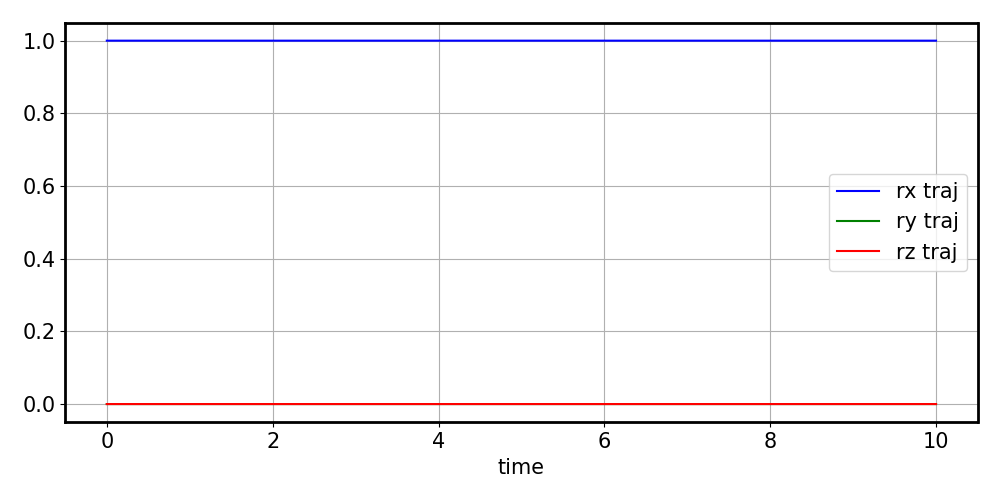

In [8]:
## Von Neumann evolution
unitary_evol = qtr_test.vonneumannAnalitical()

# Von Neumann plot
qtr.misc.rhoBlochcomp_plot(unitary_evol, qtr_test.timeList, label='traj')
plt.tight_layout()

### Diffusive trajectory

In [9]:
%%time
## Average conditional diffusive evoltuion
rho_diff = qtr_test.diffusiveRhoAverage(n_trajectories=1, method='milstein')

Compiling diffusiveRhoAverage ...
Compiling diffusiveRhoTrajectory ...
CPU times: user 28.9 s, sys: 166 ms, total: 29 s
Wall time: 31.8 s


In [10]:
%%time
# Anlitical unconditional diffusive evolution
lindblad_evol = qtr_test.lindbladAnalitical()

/home/deo/.local/lib/python3.9/site-packages/qt_unraveling/qt_unraveling.py:228: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, C))
  U_rep, M_rep, T_rep = update_defintions(t, rho)


CPU times: user 4.4 s, sys: 36.4 ms, total: 4.43 s
Wall time: 4.49 s


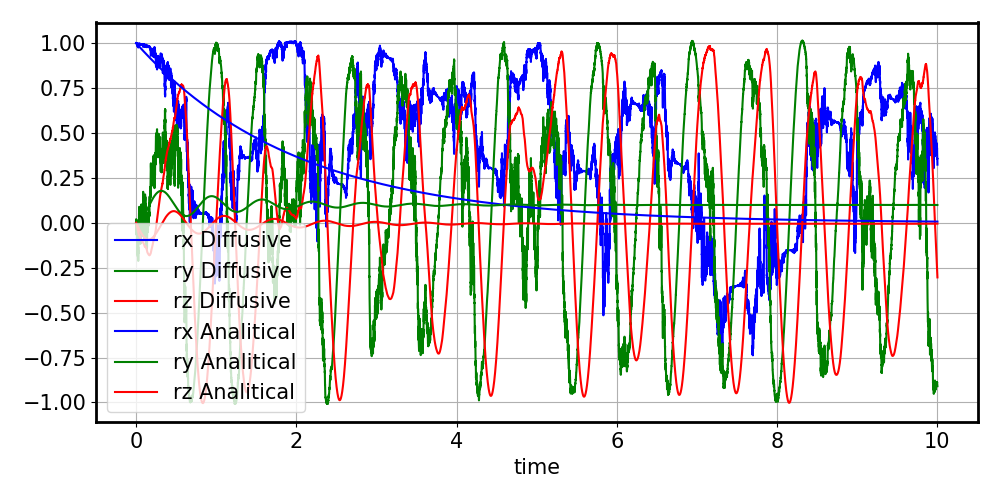

In [11]:
## Diffusive plot
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(rho_diff, qtr_test.timeList, label='Diffusive', line='-', ax=ax)
qtr.misc.rhoBlochcomp_plot(lindblad_evol, qtr_test.timeList, label='Analitical', line='-', ax=ax)
plt.tight_layout()

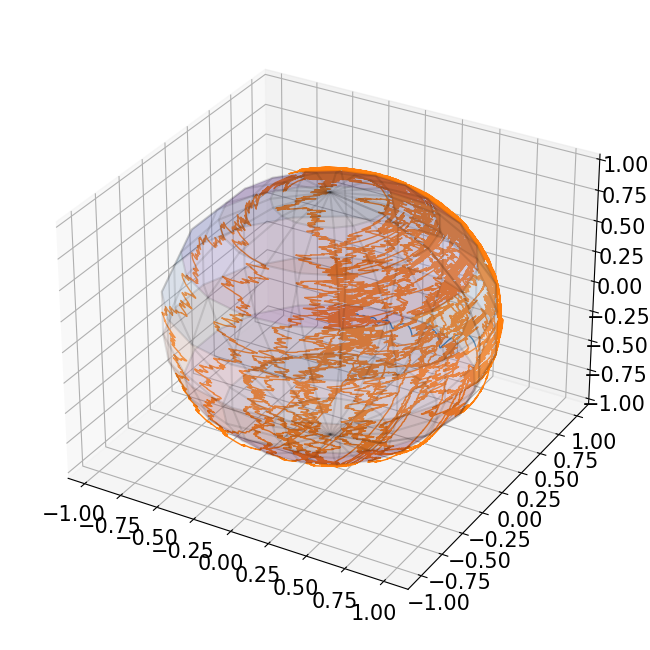

In [12]:
qtr.misc.rhoBlochSphere([lindblad_evol, rho_diff])

### Jump trajectory

In [13]:
%%time
## Average conditional Qjump evoltuion
coherent_fields = np.array([5,5], dtype=np.complex128)
rho_qjump = qtr_test.jumpRhoAverage(n_trajectories=1, coherent_fields=coherent_fields)

Compiling jumpRhoAverage ...
Compiling jumpRhoTrajectory ...
CPU times: user 10.4 s, sys: 140 ms, total: 10.5 s
Wall time: 11.8 s


In [14]:
%%time
# Anlitical unconditional diffusive evolution
lindblad_evol = qtr_test.lindbladAnalitical()

CPU times: user 126 ms, sys: 8.72 ms, total: 135 ms
Wall time: 135 ms


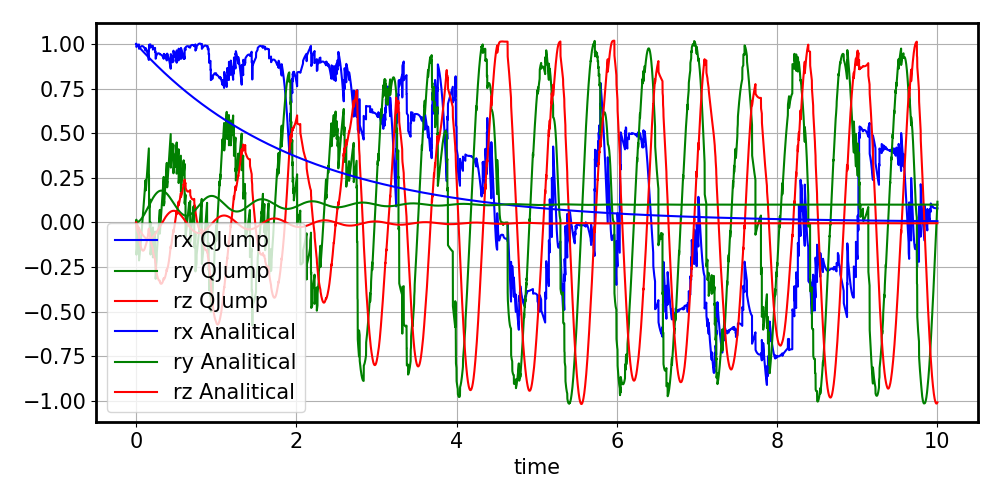

In [15]:
## Diffusive plot
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(rho_qjump, qtr_test.timeList, label='QJump', line='-', ax=ax)
qtr.misc.rhoBlochcomp_plot(lindblad_evol, qtr_test.timeList, label='Analitical', line='-', ax=ax)
plt.tight_layout()

### Quantum jump connection to the diffusive unraveling

The Qjump methods are equiped with an unraveling option that allows us to explore the continous limit of the this scheme

In [18]:
%%time
## Large coherent field mu and small time step dt
coherent_fields = np.array([5,5], dtype=np.complex128)
qjump_coh_traj = qtr_test.jumpRhoTrajectory(coherent_fields=coherent_fields, seed=5)

CPU times: user 1.47 s, sys: 4.81 ms, total: 1.47 s
Wall time: 1.49 s


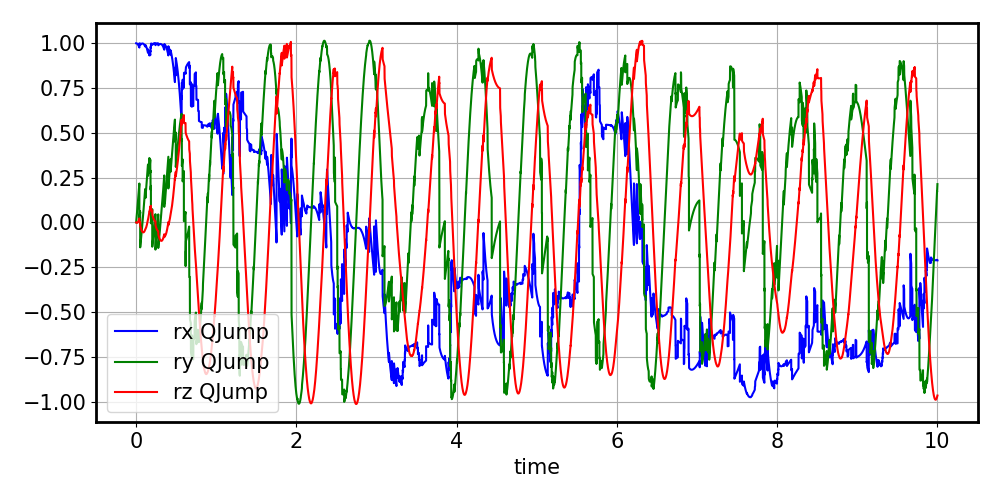

In [19]:
## Jump trajectory
qtr.misc.rhoBlochcomp_plot(qjump_coh_traj, qtr_test.timeList, label='QJump', line='-')
plt.tight_layout()

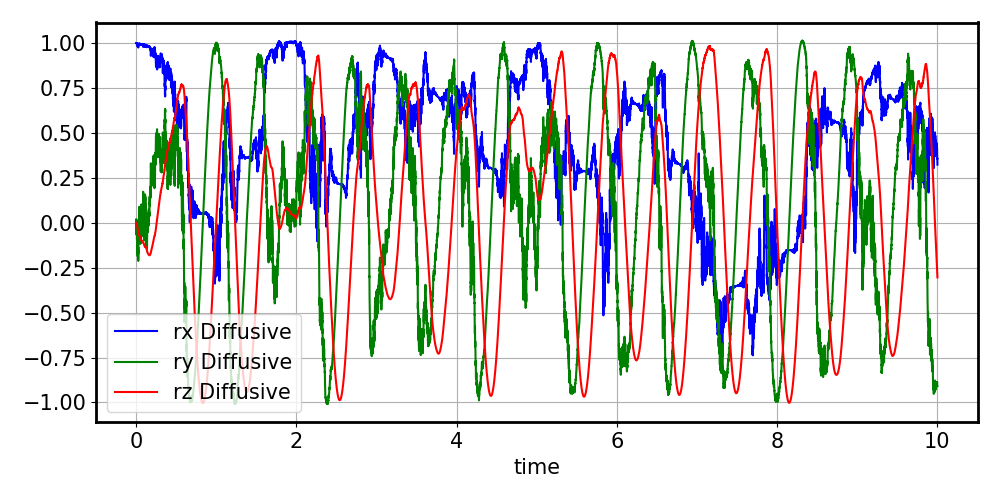

In [20]:
## Diffusive trajectory
rho_diffusive = qtr_test.diffusiveRhoTrajectory(method='milstein')

## Diffusive plot
qtr.misc.rhoBlochcomp_plot(rho_diffusive, qtr_test.timeList, label='Diffusive', line='-')
plt.tight_layout()

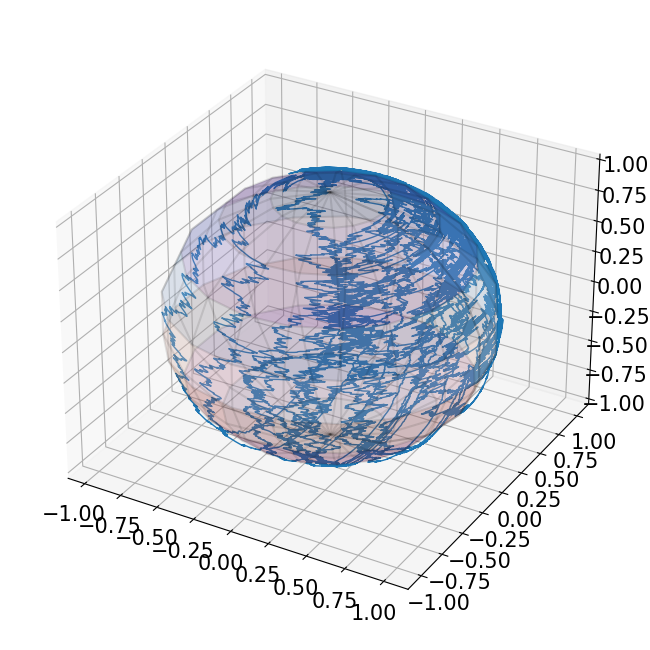

In [21]:
qtr.misc.rhoBlochSphere([rho_diffusive])